# Impulse Response Function
This notebook goes through simulation of structural VAR models (chalecki decomposition) and their Impulse Response Functions. It also goes through two different ways of analytically calculate the IRF from parametres of the sVAR models. It replicates the results of Enders p. 297

In [2]:
library(tidyverse) # readr, ggplot, dplyr, ...
library(gridExtra) # Arrangning ggplots
library(readxl)    # Loading excel
library(repr)      # Resizing the plots in jupyter
library(rugarch)   # For ARCH and GARCH models
library(dynlm)     # Lagged linear models
library(urca)      # Dick Fuller test
library(car)       # Linear hyphothesis testing
library(tseries)   # adf-test
library(vars)      # VAR models
library(zoo)       # Convert quarters to date
library(expm)      # Matrix calculations 
library(forecast)  

options(repr.plot.width=8, repr.plot.height=3)

-- Attaching packages --------------------------------------- tidyverse 1.2.1 --
v ggplot2 3.1.0     v purrr   0.2.5
v tibble  1.4.2     v dplyr   0.7.7
v tidyr   0.8.2     v stringr 1.3.1
v readr   1.1.1     v forcats 0.3.0
-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()

Attaching package: 'gridExtra'

The following object is masked from 'package:dplyr':

    combine

Loading required package: parallel

Attaching package: 'rugarch'

The following object is masked from 'package:purrr':

    reduce

The following object is masked from 'package:stats':

    sigma

Loading required package: zoo

Attaching package: 'zoo'

The following objects are masked from 'package:base':

    as.Date, as.Date.numeric

Loading required package: carData

Attaching package: 'car'

The following object is masked from 'package:dplyr':

    recode

The following object is masked from 'package:purrr'

## Function to plot IRF

In [3]:
irf_lars <- function(x, nsim = 100, p=1) {
    m <- VAR(x, p = p, type = "const")
    number <- ncol(x)
    chart_title <- substitute(paste("VAR(",p,") model with ", number," variables"))
psim <- as.data.frame(x)
psim$n <- c(1:nsim)
psim <- gather(psim, variable, value, -n)

p1 <- ggplot(psim, aes(n, value, linetype=variable)) + 
 geom_line(color="#045a8d") + 
 labs(title=chart_title, x="", y="")

data <- irf(m, nsteps = 12, n.ahead=20)
variables <- data$irf %>% names

ir <- lapply(1:length(variables), function(e){
    data_to_plot <- data.frame(data %>% `$`(irf) %>% `[[`(variables[e])) %>%
      mutate("t" = 1:NROW(.)) %>%
      gather(.,Variable, Value, -t)

    upper_ci <- data.frame(data %>% `$`(Upper) %>% `[[`(variables[e])) %>%
      mutate("t" = 1:NROW(.)) %>%
      gather(.,Variable, Upper, -t)

    lower_ci <- data.frame(data %>% `$`(Lower) %>% `[[`(variables[e]) ) %>%
      mutate("t" = 1:NROW(.)) %>%
      gather(.,Variable, Lower, -t)

    res <- inner_join(data_to_plot, upper_ci, c("t","Variable")) %>%
           inner_join(.,lower_ci, c("t","Variable")) %>%
           mutate(impulse = paste("Shock to", variables[e])) 
}) %>% bind_rows

p2 <- ggplot(ir, aes(x = t, y = Value, group = Variable))  +
  geom_line(color="#045a8d") +
  geom_ribbon(aes(x=t, ymax=Upper, ymin=Lower), alpha=0.15, fill="#045a8d") +
  scale_x_continuous(limits = c(0,21), breaks = seq(0,20,4)) +
  scale_y_continuous("", position="right") +
  labs(title="Impulse Response Functions", x="") +
  facet_grid(Variable ~ impulse, switch="y")

grid.arrange(p1,p2, nrow=1)
}

Important both models are limited in that they contain a identification restriction
$$ e_{1t} = \varepsilon_{yt} - b_{12}\varepsilon_{zt}$$
$$ e_{2t} = \varepsilon_{zt} $$
This means that there is no contemporary effect from $y_t$ to $z_t$ but only the other way round. In effect this is implemented as:
$$ e_{1t} = \varepsilon_{yt} + 0.8\varepsilon_{zt}$$
$$ e_{2t} = \varepsilon_{zt} $$

# 2 variable sVAR model - positive off-diagonal elements of $A_1$

In [4]:
yt <- c(0)
zt <- c(0)
nsim <- 200

for (i in 2:nsim) {
    ey <- rnorm(1)
    ez <- rnorm(1)
    yt[i] <- 0.7*yt[i-1] + 0.2*zt[i-1] + (ey)
    zt[i] <- 0.7*zt[i-1] + 0.2*yt[i-1] + (ez+0.8*ey)
}
sim <- cbind(zt, yt)

$$
\begin{bmatrix} y_t \\ z_t \end{bmatrix}
=
\begin{bmatrix} 0.7 & 0.2 \\ 0.2 & 0.7 \end{bmatrix}
\cdot
\begin{bmatrix} y_{t-1} \\ z_{t-1} \end{bmatrix}
+
\begin{bmatrix} e_{1t} \\ e_{2t} \end{bmatrix}
\qquad
B_0 = \begin{bmatrix} 1 & 0.8 \\ 0 & 1 \end{bmatrix}
$$

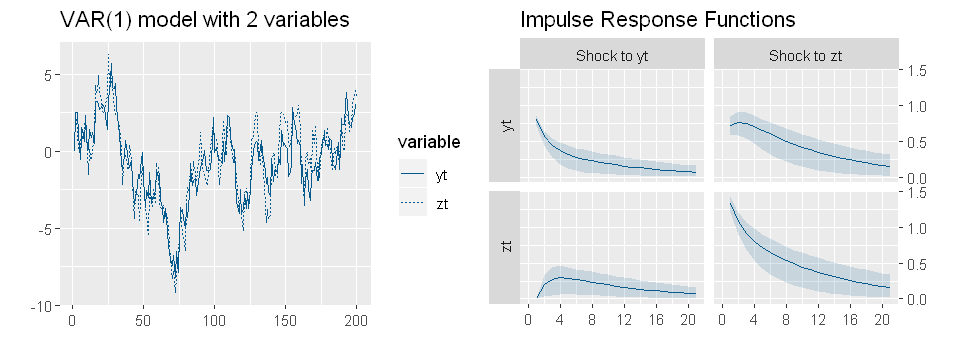

In [5]:
irf_lars(sim, nsim=200, p=1)

In [12]:
# VAR(sim, p = 1, type = "const")

# 2 variable sVAR model - negative off-diagonal elements of $A_1$

In [28]:
yt <- c(0)
zt <- c(0)
nsim <- 200

for (i in 2:nsim) {
    ey <- rnorm(1) 
    ez <- rnorm(1)
    yt[i] <- 0.7*yt[i-1] - 0.2*zt[i-1] + (ey + 0.8*ez)
    zt[i] <- 0.7*zt[i-1] - 0.2*yt[i-1] + (ez)
}
sim2 <- cbind(zt, yt)

$$
\begin{bmatrix} y_t \\ z_t \end{bmatrix}
=
\begin{bmatrix} 0.7 & -0.2 \\ -0.2 & 0.7 \end{bmatrix}
\cdot
\begin{bmatrix} y_{t-1} \\ z_{t-1} \end{bmatrix}
+
\begin{bmatrix} e_{1t} \\ e_{2t} \end{bmatrix}
\qquad
B_0 = \begin{bmatrix} 1 & 0 \\ 0.8 & 1 \end{bmatrix}
$$

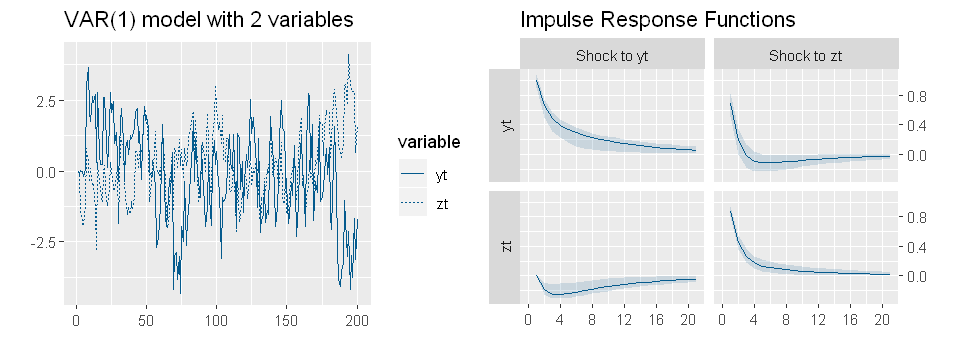

In [29]:
irf_lars(sim2, nsim=200, p=1)

In [15]:
# VAR(sim2, p = 1, type = "const")

In [16]:
#m <- VAR(as.ts(sim2), p = 1, type = "const")
#forecast(m) %>% autoplot()

# 3 variable VAR model

First we need to check a system of equations which is stationary

In [17]:
yy=0.5; yz=0.2; yx=0.1
zy=0.2; zz=0.1; zx=0.1
xy=0.1; xz=0.3; xx=0.9

ma <- matrix(c(yy, yz, yx,
               zy, zz, zx,
               xy, xz, xx), nrow=3, byrow=T)
ma

print(Mod(eigen(ma)$values))

0.5,0.2,0.1
0.2,0.1,0.1
0.1,0.3,0.9


[1] 0.981341767 0.516686024 0.001972209


If the values are all within unity we can proceed

In [32]:
yt <- c(0)
zt <- c(0)
xt <- c(0)
nsim <- 200

for (i in 2:nsim) {
    ey <- rnorm(1) 
    ez <- rnorm(1)
    ex <- rnorm(1)
    yt[i] <- yy*yt[i-1] + yz*zt[i-1] + yx*xt[i-1] + ey
    zt[i] <- zy*yt[i-1] + zz*zt[i-1] + zx*xt[i-1] + ez
    xt[i] <- xy*yt[i-1] + xz*zt[i-1] + xx*xt[i-1] + ex
}
sim <- cbind(zt, yt, xt)

$$
\begin{bmatrix} y_t \\ z_t \\ x_t \end{bmatrix}
=
\begin{bmatrix} 0.5 & 0.2 & 0.1 \\ 0.2 & 0.1 & 0.1 \\ 0.1 & 0.3 & 0.9 \end{bmatrix}
\cdot
\begin{bmatrix} y_{t-1} \\ z_{t-1} \\ x_{t-1} \end{bmatrix}
+
\begin{bmatrix} e_{1t} \\ e_{2t} \\ e_{3t} \end{bmatrix}
\qquad
B_0 = \begin{bmatrix} 1 & 0 & 0 \\ 0 & 1 & 0 \\ 0 & 0 & 1 \end{bmatrix}
$$

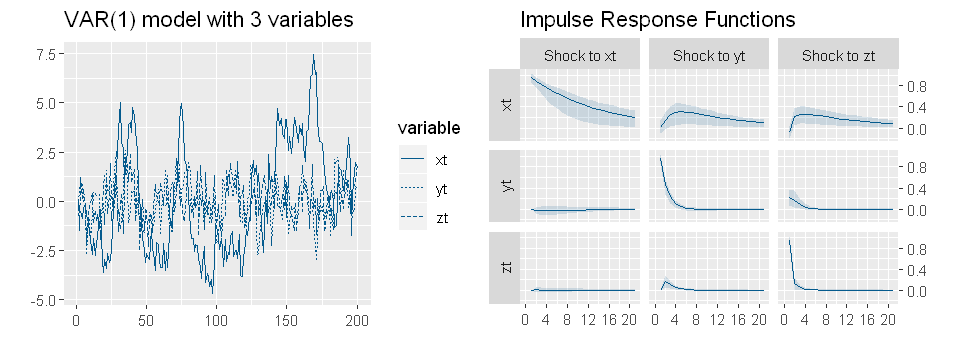

In [32]:
irf_lars(sim, nsim=200, p=1)

## How manny lags do the vars package suggest by different selection models?
The answer is by no surprise 1, as we simulates data with 1 lag.

In [116]:
print(VARselect(sim, lag.max=8, type="const")[["selection"]])

AIC(n)  HQ(n)  SC(n) FPE(n) 
     1      1      1      1 


In [117]:
#m <- VAR(as.ts(sim), p = 1, type = "const")
#forecast(m) %>% autoplot()

# 3 variable sVAR model
First i calculate the number of restricted paramatres i need

In [23]:
n <- 3
(n^2-n)/2

[1] 3

I then apply the choleski decomposition as can be seen from the $B_0$ matrix, it's important that the ordering makes sense because it changes the response functions. the order i use is $\{y_t, z_t, x_t\}$

In [35]:
rm(ey); rm(ex); rm(ez)

yy=0.5; yz=0.0; yx=0.0
zy=0.2; zz=0.1; zx=0.0
xy=0.1; xz=0.3; xx=0.9

ma <- matrix(c(yy, yz, yx,
               zy, zz, zx,
               xy, xz, xx), nrow=3, byrow=T)

print(Mod(eigen(ma)$values))

yt <- c(0)
zt <- c(0)
xt <- c(0)
nsim <- 200

for (i in 2:nsim) {
    ey <- rnorm(1) 
    ez <- rnorm(1) + 0.7*ey
    ex <- rnorm(1) + 0.7*ey + 0.7*ez
    yt[i] <- yy*yt[i-1] + yz*zt[i-1] + yx*xt[i-1] + ey
    zt[i] <- zy*yt[i-1] + zz*zt[i-1] + zx*xt[i-1] + ez
    xt[i] <- xy*yt[i-1] + xz*zt[i-1] + xx*xt[i-1] + ex
}
sim <- cbind(zt, yt, xt)

[1] 0.9 0.5 0.1


$$
\begin{bmatrix} y_t \\ z_t \\ x_t \end{bmatrix}
=
\begin{bmatrix} 0.5 & 0.0 & 0.0 \\ 0.2 & 0.1 & 0.0 \\ 0.1 & 0.3 & 0.9 \end{bmatrix}
\cdot
\begin{bmatrix} y_{t-1} \\ z_{t-1} \\ x_{t-1} \end{bmatrix}
+
\begin{bmatrix} e_{1t} \\ e_{2t} \\ e_{3t} \end{bmatrix}
\qquad
B_0 = \begin{bmatrix} 1 & 0 & 0 \\ 0.7 & 1 & 0 \\ 0.7 & 0.7 & 1 \end{bmatrix}
$$

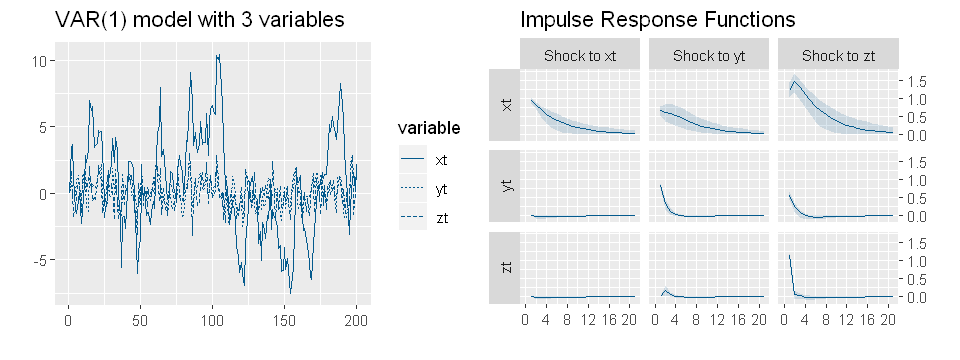

In [36]:
irf_lars(sim, nsim=200, p=1)

In [37]:
#VAR(sim, p = 1, type = "const")

# Analytic solution by matrix

$$
\phi_i = \frac{A^i_1}{1-b_{12}b_{21}}
\begin{bmatrix} 1 & b_{12} \\ b_{21} & 1 \end{bmatrix}
$$

In pratice when we use the parametres, and a choleski decomposition from the first model we can do the following:

$$
\phi_i = \frac{A^i_1}{1-0 * 0.8}
\begin{bmatrix} 1 & 0 \\ 0.8 & 1 \end{bmatrix}
$$

$$
\phi_i = A^i_1
\begin{bmatrix} 1 & 0 \\ 0.8 & 1 \end{bmatrix}
$$

$$
\phi_i = 
\begin{bmatrix} 0.7 & 0.2 \\ 0.2 & 0.7 \end{bmatrix}^i
\begin{bmatrix} 1 & 0 \\ 0.8 & 1 \end{bmatrix}
$$

In [38]:
A <- matrix(c(0.7,0.2,0.2,0.7), byrow=T,nrow=2)
b <- matrix(c(1,0,0.8,1), byrow=T,nrow=2)

row <- data.frame(NA,NA,NA,NA)

for (i in 0:19) {
    row[i+1,] <- t(as.vector(b %*% (A %^% i)))
}

row$n <- 1:20
colnames(row) <- c("1. shock in yt on yt", "2. shock in zt on yt", "3. shock in yt on zt", "4. shock in zt on zt", "n")
df <- gather(row, variable, value, -n)

p1 <- ggplot(df, aes(n, value)) + 
geom_line() + 
facet_wrap(~variable) + 
labs(title="Matrix solution")

head(row)

1. shock in yt on yt,2. shock in zt on yt,3. shock in yt on zt,4. shock in zt on zt,n
1.00000,0.800000,0.00000,1.000000,1
0.70000,0.760000,0.20000,0.860000,2
0.53000,0.704000,0.28000,0.754000,3
0.42700,0.643600,0.30200,0.668600,4
0.35930,0.584240,0.29680,0.596740,5
0.31087,0.528316,0.27962,0.534566,6


# Analytic solution by iteration

In [39]:
yt <- c(0)
zt <- c(0)
yt2 <- c(0)
zt2 <- c(0)
nsim <- 21

for (i in 2:nsim) {
    ey <- c(rep(0,21))
    ez <- c(1,rep(0,20))
    yt[i] <- 0.7*yt[i-1] + 0.2*zt[i-1] + (ey[i-1]+0.8*ez[i-1])
    zt[i] <- 0.7*zt[i-1] + 0.2*yt[i-1] + (ez[i-1])
}

for (i in 2:nsim) {
    ey <- c(1,rep(0,20))
    ez <- c(rep(0,21))
    yt2[i] <- 0.7*yt2[i-1] + 0.2*zt2[i-1] + (ey[i-1]+0.8*ez[i-1])
    zt2[i] <- 0.7*zt2[i-1] + 0.2*yt2[i-1] + (ez[i-1])
}

row <- as.data.frame(cbind(zt,zt2,yt,yt2))[-1,]
row$n <- 1:20
colnames(row) <- c("4. shock in zt on zt", "3. shock in yt on zt", "2. shock in zt on yt", "1. shock in yt on yt", "n")
df <- gather(row, variable, value, -n)

p2 <- ggplot(df, aes(n, value)) + 
geom_line() + 
facet_wrap(~variable) + 
labs(title="Iterative solution")

head(row)

,4. shock in zt on zt,3. shock in yt on zt,2. shock in zt on yt,1. shock in yt on yt,n
2,1.000000,0.00000,0.800000,1.00000,1
3,0.860000,0.20000,0.760000,0.70000,2
4,0.754000,0.28000,0.704000,0.53000,3
5,0.668600,0.30200,0.643600,0.42700,4
6,0.596740,0.29680,0.584240,0.35930,5
7,0.534566,0.27962,0.528316,0.31087,6


$$
\begin{bmatrix} y_t \\ z_t \end{bmatrix}
=
\begin{bmatrix} 0.7 & 0.2 \\ 0.2 & 0.7 \end{bmatrix}
\cdot
\begin{bmatrix} y_{t-1} \\ z_{t-1} \end{bmatrix}
+
\begin{bmatrix} e_{1t} \\ e_{2t} \end{bmatrix}
$$

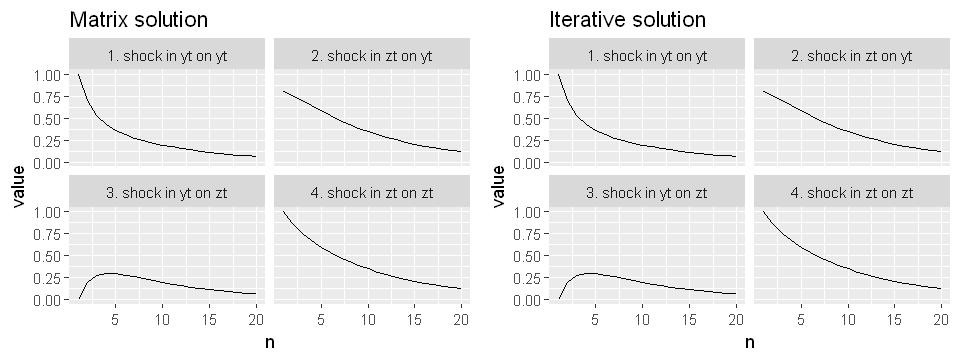

In [40]:
grid.arrange(p1,p2,nrow=1)